In [214]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [146]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
N_CLASS = 3

In [176]:
# conjunto de entrenamiento
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '../train',  
    shuffle=True,
    image_size=((IMAGE_SIZE,IMAGE_SIZE)),
    batch_size=BATCH_SIZE
)

# conjunto de validación
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '../validation',  
    shuffle=True,
    image_size=((IMAGE_SIZE,IMAGE_SIZE)),
    batch_size=BATCH_SIZE
)

# conjunto de prueba
test_dataset = tf.keras.utils.image_dataset_from_directory(
    '../test',  
    shuffle=True,
    image_size=((IMAGE_SIZE,IMAGE_SIZE)),
    batch_size=BATCH_SIZE
)

Found 8970 files belonging to 3 classes.
Found 1121 files belonging to 3 classes.
Found 1122 files belonging to 3 classes.


In [62]:
class_name = train_dataset.class_names
class_name

['birds', 'cats', 'dogs']

In [64]:
print (len(train_dataset))
print (len(validation_dataset))
print (len(test_dataset))

281
36
36


In [65]:
print (281 *  32)
print (36 *  32)
print (36 *  32)

8992
1152
1152


Las dimensiones de las batch de imagenes son: (32, 256, 256, 3), y las clases serían: [1 2 0 2 2 1 1 1 1 0 1 1 1 2 2 0 2 0 2 1 2 1 2 1 2 1 2 2 0 2 2 0]


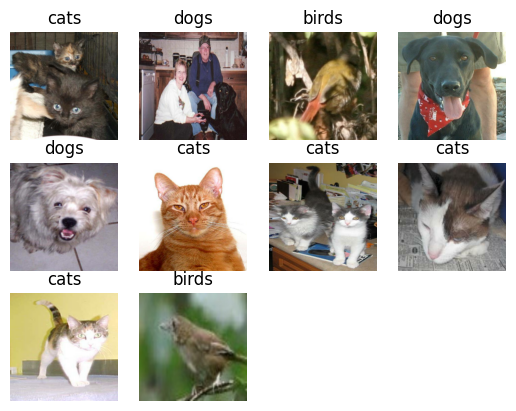

In [177]:
for image_batch, label_batch in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_name[label_batch[i]])
    print(f"Las dimensiones de las batch de imagenes son: {image_batch.shape}, y las clases serían: {label_batch.numpy()}")

In [178]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)


In [179]:
# Voy a reescalar las imagenes así mantengo un formato para todas y además las normalizo
rescale_resize_layers = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [68]:
# data_augmentation_layer = tf.keras.Sequential([
#     layers.RandomFlip('horizontal_and_vertical'),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(factor=(0.2, 0.5))
# ])


In [180]:
data_augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(factor=(0.2, 0.5)),
    # layer nuevo
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')
])


In [69]:
model = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = INPUT_SHAPE),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(N_CLASS, activation = 'softmax')
])

In [70]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [90]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  
)


In [72]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,  
    callbacks=[early_stop, model_checkpoint]  
)


Epoch 1/25


281/281 [==============================] - ETA: 0s - loss: 1.0323 - accuracy: 0.4350
Epoch 1: val_loss improved from inf to 0.94127, saving model to model_best.h5
281/281 [==============================] - 164s 568ms/step - loss: 1.0323 - accuracy: 0.4350 - val_loss: 0.9413 - val_accuracy: 0.5281
Epoch 2/25
281/281 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.4970
Epoch 2: val_loss did not improve from 0.94127
281/281 [==============================] - 160s 568ms/step - loss: 0.9658 - accuracy: 0.4970 - val_loss: 0.9443 - val_accuracy: 0.5031
Epoch 3/25
281/281 [==============================] - ETA: 0s - loss: 0.9335 - accuracy: 0.5154
Epoch 3: val_loss improved from 0.94127 to 0.90683, saving model to model_best.h5
281/281 [==============================] - 159s 568ms/step - loss: 0.9335 - accuracy: 0.5154 - val_loss: 0.9068 - val_accuracy: 0.5433
Epoch 4/25
281/281 [==============================] - ETA: 0s - loss: 0.9242 - accuracy: 0.5244
Ep

In [73]:
# Antes de seguir entrenandolo, voy a evaluarlo y gráficar loss/accuraccy según epoch

scores = model.evaluate(test_dataset)

36/36 [==============================] - 4s 120ms/step - loss: 0.5183 - accuracy: 0.7799


In [74]:
scores

[0.5182622671127319, 0.7798573970794678]

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [86]:
for i in range(len(history.history['loss'])):
    print(f"Época {i+1}, Pérdida: {history.history['loss'][i]}, Precisión: {history.history['accuracy'][i]}")



Época 1, Pérdida: 1.0322520732879639, Precisión: 0.4350055754184723
Época 2, Pérdida: 0.9657716751098633, Precisión: 0.4969899654388428
Época 3, Pérdida: 0.9335286617279053, Precisión: 0.5153846144676208
Época 4, Pérdida: 0.924201250076294, Precisión: 0.5244147181510925
Época 5, Pérdida: 0.9084658622741699, Precisión: 0.538127064704895
Época 6, Pérdida: 0.8885790109634399, Precisión: 0.5599777102470398
Época 7, Pérdida: 0.872300922870636, Precisión: 0.5712374448776245
Época 8, Pérdida: 0.842216432094574, Precisión: 0.588182806968689
Época 9, Pérdida: 0.8181187510490417, Precisión: 0.6117056608200073
Época 10, Pérdida: 0.7910177707672119, Precisión: 0.626086950302124
Época 11, Pérdida: 0.7643959522247314, Precisión: 0.6487179398536682
Época 12, Pérdida: 0.7387688755989075, Precisión: 0.6613155007362366
Época 13, Pérdida: 0.7123034000396729, Precisión: 0.6777034401893616
Época 14, Pérdida: 0.6796100735664368, Precisión: 0.6906354427337646
Época 15, Pérdida: 0.6572630405426025, Precisión:

In [87]:
for i in range(len(history.history['val_loss'])):
    print(f"Época {i+1}, Pérdida de Validación: {history.history['val_loss'][i]}, Precisión de Validación: {history.history['val_accuracy'][i]}")


Época 1, Pérdida de Validación: 0.941268265247345, Precisión de Validación: 0.5280998945236206
Época 2, Pérdida de Validación: 0.9443221092224121, Precisión de Validación: 0.5031222105026245
Época 3, Pérdida de Validación: 0.9068319201469421, Precisión de Validación: 0.5432649254798889
Época 4, Pérdida de Validación: 0.9152588248252869, Precisión de Validación: 0.5138269662857056
Época 5, Pérdida de Validación: 0.8919326663017273, Precisión de Validación: 0.5468331575393677
Época 6, Pérdida de Validación: 0.9033916592597961, Precisión de Validación: 0.5825155973434448
Época 7, Pérdida de Validación: 0.816112220287323, Precisión de Validación: 0.624442458152771
Época 8, Pérdida de Validación: 0.8326470255851746, Precisión de Validación: 0.5905441641807556
Época 9, Pérdida de Validación: 0.8009136319160461, Precisión de Validación: 0.6164138913154602
Época 10, Pérdida de Validación: 0.7330822944641113, Precisión de Validación: 0.6708295941352844
Época 11, Pérdida de Validación: 0.7551632

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

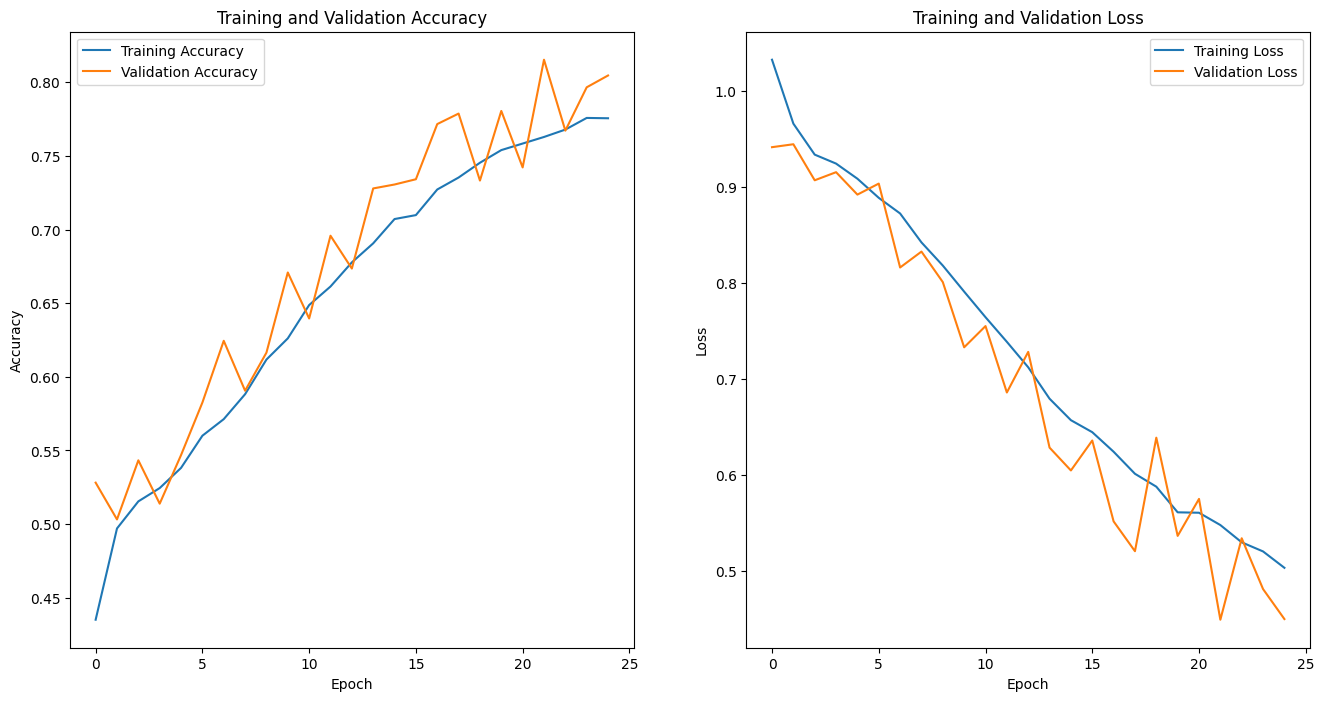

In [89]:
# Precisión
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [91]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,  
    callbacks=[early_stop, model_checkpoint]  
)


Epoch 1/25
281/281 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7883
Epoch 1: val_loss improved from inf to 0.51179, saving model to model_best.h5
281/281 [==============================] - 149s 529ms/step - loss: 0.4891 - accuracy: 0.7883 - val_loss: 0.5118 - val_accuracy: 0.7877
Epoch 2/25
281/281 [==============================] - ETA: 0s - loss: 0.5039 - accuracy: 0.7902
Epoch 2: val_loss did not improve from 0.51179
281/281 [==============================] - 146s 521ms/step - loss: 0.5039 - accuracy: 0.7902 - val_loss: 0.5968 - val_accuracy: 0.7725
Epoch 3/25
281/281 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.7988
Epoch 3: val_loss improved from 0.51179 to 0.45132, saving model to model_best.h5
281/281 [==============================] - 148s 526ms/step - loss: 0.4799 - accuracy: 0.7988 - val_loss: 0.4513 - val_accuracy: 0.8171
Epoch 4/25
281/281 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8036
Epoc

In [145]:
scores2 = model.evaluate(test_dataset)
scores2

36/36 [==============================] - 5s 135ms/step - loss: 0.4674 - accuracy: 0.8021


[0.46743229031562805, 0.8021390438079834]

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [98]:
for i in range(len(history.history['loss'])):
    print(f"Época {i+1}, Pérdida: {history.history['loss'][i]}, Precisión: {history.history['accuracy'][i]}")



for i in range(len(history.history['val_loss'])):
    print(f"Época {i+1}, Pérdida de Validación: {history.history['val_loss'][i]}, Precisión de Validación: {history.history['val_accuracy'][i]}")


Época 1, Pérdida: 0.4891192317008972, Precisión: 0.7882943153381348
Época 2, Pérdida: 0.5039323568344116, Precisión: 0.7901895046234131
Época 3, Pérdida: 0.4798937439918518, Precisión: 0.7987737059593201
Época 4, Pérdida: 0.46675559878349304, Precisión: 0.8035674691200256
Época 5, Pérdida: 0.44977977871894836, Precisión: 0.8120401501655579
Época 6, Pérdida: 0.4426780641078949, Precisión: 0.8124860525131226
Época 7, Pérdida: 0.43084612488746643, Precisión: 0.8172798156738281
Época 8, Pérdida: 0.4296260476112366, Precisión: 0.8182831406593323
Época 9, Pérdida: 0.4066420793533325, Precisión: 0.8315495848655701
Época 10, Pérdida: 0.4108451008796692, Precisión: 0.8309922218322754
Época 11, Pérdida: 0.3998023569583893, Precisión: 0.8342251777648926
Época 12, Pérdida: 0.3844876289367676, Precisión: 0.8451505303382874
Época 1, Pérdida de Validación: 0.5117876529693604, Precisión de Validación: 0.7876895666122437
Época 2, Pérdida de Validación: 0.5967823266983032, Precisión de Validación: 0.772

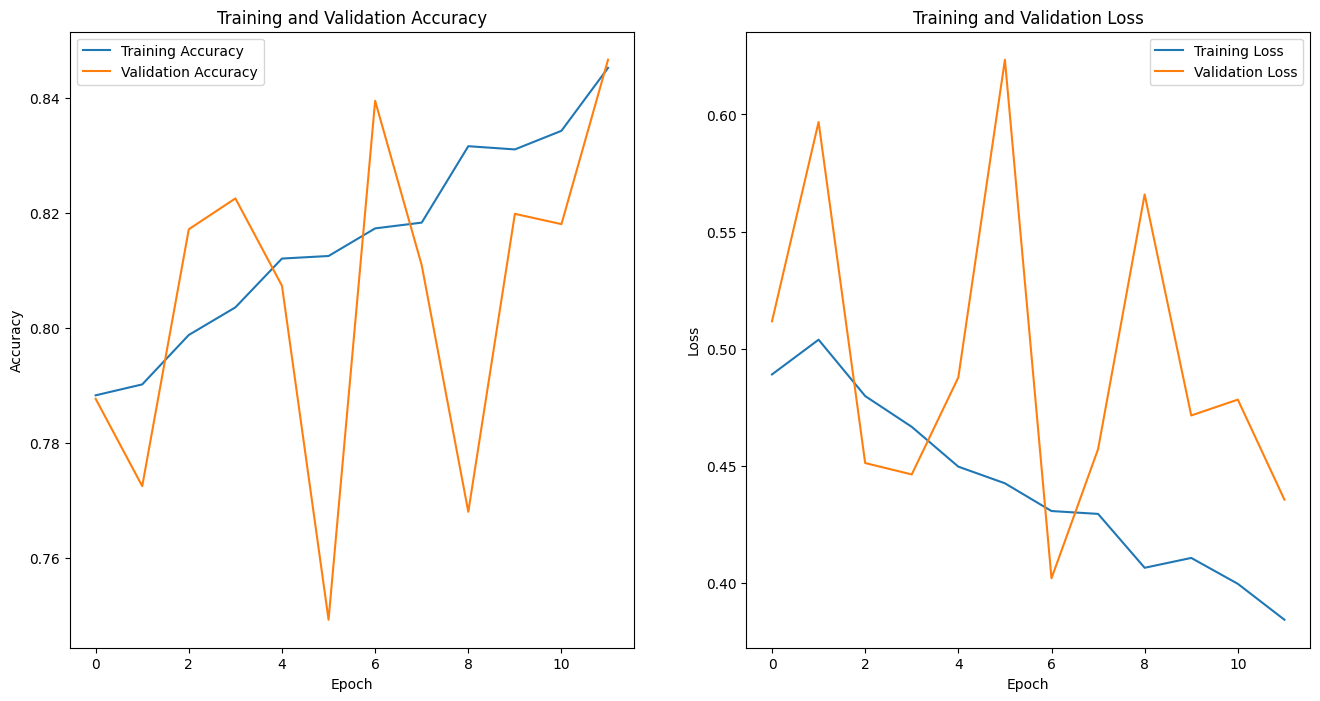

In [97]:
# Precisión
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(12), acc, label='Training Accuracy')
plt.plot(range(12), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(range(12), loss, label='Training Loss')
plt.plot(range(12), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Voy a probar con la misma estructura pero añadiendo regulaciones dropout y jugando con el learning rate

In [111]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [107]:

0.001 * np.exp(-0.1)

0.0009048374180359595

In [105]:
model2 = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASS, activation='softmax')
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [102]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best_2.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  
)


In [108]:
history2 = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=37,  
    callbacks=[early_stop, model_checkpoint,lr_scheduler]
)


Epoch 1/37
281/281 [==============================] - ETA: 0s - loss: 1.0786 - accuracy: 0.3838
Epoch 1: val_loss improved from inf to 1.04548, saving model to model_best_2.h5
281/281 [==============================] - 202s 712ms/step - loss: 1.0786 - accuracy: 0.3838 - val_loss: 1.0455 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 2/37
281/281 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.4677
Epoch 2: val_loss improved from 1.04548 to 0.96978, saving model to model_best_2.h5
281/281 [==============================] - 188s 670ms/step - loss: 1.0053 - accuracy: 0.4677 - val_loss: 0.9698 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 3/37
281/281 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.4944
Epoch 3: val_loss improved from 0.96978 to 0.94920, saving model to model_best_2.h5
281/281 [==============================] - 187s 667ms/step - loss: 0.9855 - accuracy: 0.4944 - val_loss: 0.9492 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 4/37
281/281 [

36/36 [==============================] - 4s 110ms/step - loss: 0.5995 - accuracy: 0.7308
Época 1, Pérdida: 1.0786124467849731, Precisión: 0.3838350176811218
Época 2, Pérdida: 1.0053232908248901, Precisión: 0.4676700234413147
Época 3, Pérdida: 0.9855251908302307, Precisión: 0.49442586302757263
Época 4, Pérdida: 0.9686806201934814, Precisión: 0.5036789178848267
Época 5, Pérdida: 0.9724246859550476, Precisión: 0.5046823024749756
Época 6, Pérdida: 0.9438050985336304, Precisión: 0.516387939453125
Época 7, Pérdida: 0.9457860589027405, Precisión: 0.5115941762924194
Época 8, Pérdida: 0.9449353814125061, Precisión: 0.514158308506012
Época 9, Pérdida: 0.9164690971374512, Precisión: 0.5421404838562012
Época 10, Pérdida: 0.8882529139518738, Precisión: 0.557748019695282
Época 11, Pérdida: 0.8844023942947388, Precisión: 0.5616499185562134
Época 12, Pérdida: 0.8618441820144653, Precisión: 0.582720160484314
Época 13, Pérdida: 0.8375508785247803, Precisión: 0.5936455130577087
Época 14, Pérdida: 0.82776

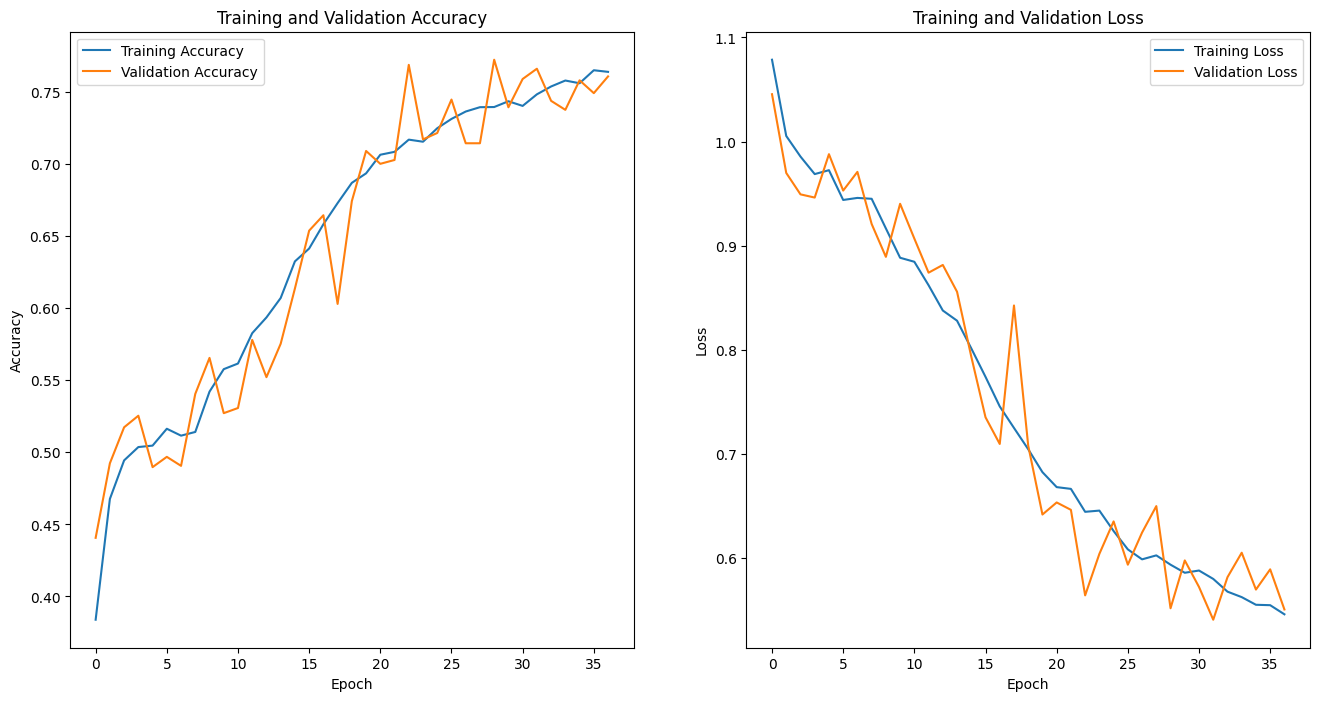

In [110]:
scores3 = model2.evaluate(test_dataset)
scores3

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

for i in range(len(history2.history['loss'])):
    print(f"Época {i+1}, Pérdida: {history2.history['loss'][i]}, Precisión: {history2.history['accuracy'][i]}")



for i in range(len(history2.history['val_loss'])):
    print(f"Época {i+1}, Pérdida de Validación: {history2.history['val_loss'][i]}, Precisión de Validación: {history2.history['val_accuracy'][i]}")


# Precisión
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(37), acc, label='Training Accuracy')
plt.plot(range(37), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(range(37), loss, label='Training Loss')
plt.plot(range(37), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Un tercer modelo

In [112]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * 0.5
    elif epoch < 30:
        return lr * 0.2
    else:
        return lr * np.exp(-0.1 * (epoch - 29))

    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [114]:
model3 = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  
    

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASS, activation='softmax')
])

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [115]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best_3.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  
)


In [116]:
history3 = model3.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=37,  
    callbacks=[early_stop, model_checkpoint,lr_scheduler]
)


Epoch 1/37
281/281 [==============================] - ETA: 0s - loss: 1.1874 - accuracy: 0.4672
Epoch 1: val_loss improved from inf to 1.10773, saving model to model_best_3.h5
281/281 [==============================] - 244s 863ms/step - loss: 1.1874 - accuracy: 0.4672 - val_loss: 1.1077 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 2/37
281/281 [==============================] - ETA: 0s - loss: 0.9394 - accuracy: 0.5408
Epoch 2: val_loss improved from 1.10773 to 0.99913, saving model to model_best_3.h5
281/281 [==============================] - 243s 866ms/step - loss: 0.9394 - accuracy: 0.5408 - val_loss: 0.9991 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 3/37
281/281 [==============================] - ETA: 0s - loss: 0.8734 - accuracy: 0.5854
Epoch 3: val_loss did not improve from 0.99913
281/281 [==============================] - 247s 879ms/step - loss: 0.8734 - accuracy: 0.5854 - val_loss: 1.4523 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 4/37
281/281 [==============================] - ETA

36/36 [==============================] - 8s 227ms/step - loss: 0.4903 - accuracy: 0.7870
Época 1, Pérdida: 1.1873648166656494, Precisión: 0.4672240912914276
Época 2, Pérdida: 0.9393771290779114, Precisión: 0.5408026576042175
Época 3, Pérdida: 0.8733818531036377, Precisión: 0.5853957533836365
Época 4, Pérdida: 0.8087432384490967, Precisión: 0.6308807134628296
Época 5, Pérdida: 0.7752512693405151, Precisión: 0.6467112302780151
Época 6, Pérdida: 0.7195228934288025, Precisión: 0.6787068247795105
Época 7, Pérdida: 0.6954633593559265, Precisión: 0.6928651332855225
Época 8, Pérdida: 0.6678197979927063, Precisión: 0.7111482620239258
Época 9, Pérdida: 0.6478852033615112, Precisión: 0.7216276526451111
Época 10, Pérdida: 0.6176522970199585, Precisión: 0.73366779088974
Época 11, Pérdida: 0.5576497912406921, Precisión: 0.7614269852638245
Época 12, Pérdida: 0.49333298206329346, Precisión: 0.7924191951751709
Época 13, Pérdida: 0.4598531126976013, Precisión: 0.8095875382423401
Época 14, Pérdida: 0.430

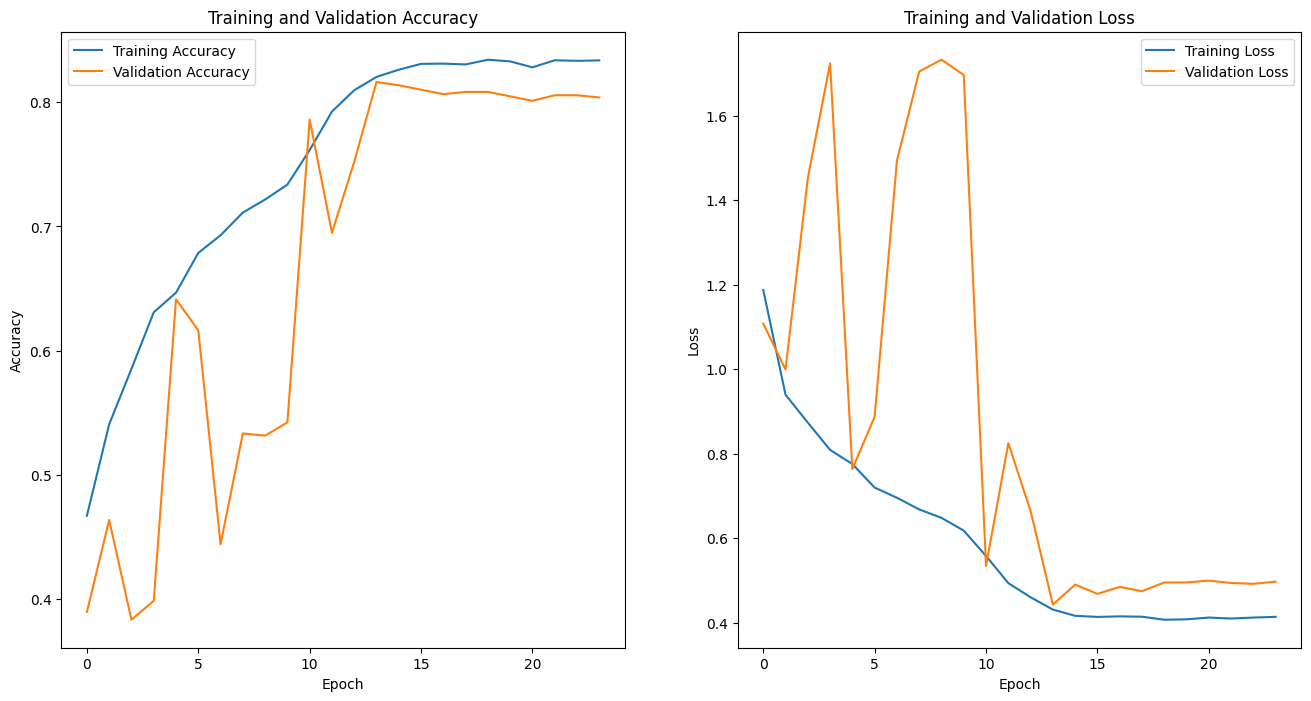

In [117]:
scores4 = model3.evaluate(test_dataset)
scores4

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

for i in range(len(history3.history['loss'])):
    print(f"Época {i+1}, Pérdida: {history3.history['loss'][i]}, Precisión: {history3.history['accuracy'][i]}")



for i in range(len(history3.history['val_loss'])):
    print(f"Época {i+1}, Pérdida de Validación: {history3.history['val_loss'][i]}, Precisión de Validación: {history3.history['val_accuracy'][i]}")


# Precisión
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(24), acc, label='Training Accuracy')
plt.plot(range(24), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(range(24), loss, label='Training Loss')
plt.plot(range(24), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 4to modelo

In [119]:
model4 = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(N_CLASS, activation='softmax')
])

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.005, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best_4.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  )


callbacks = [early_stop, model_checkpoint, reduce_lr]

In [120]:
history4 = model4.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 1.2668 - accuracy: 0.4093
Epoch 1: val_loss improved from inf to 1.08131, saving model to model_best_4.h5
281/281 [==============================] - 271s 957ms/step - loss: 1.2668 - accuracy: 0.4093 - val_loss: 1.0813 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 1.0268 - accuracy: 0.4730
Epoch 2: val_loss improved from 1.08131 to 1.03145, saving model to model_best_4.h5
281/281 [==============================] - 266s 946ms/step - loss: 1.0268 - accuracy: 0.4730 - val_loss: 1.0315 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.4918
Epoch 3: val_loss improved from 1.03145 to 0.97909, saving model to model_best_4.h5
281/281 [==============================] - 265s 942ms/step - loss: 0.9731 - accuracy: 0.4918 - val_loss: 0.9791 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 4/50
281/281 [

In [124]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Args:
    - history: A TensorFlow History object from a model training session.

    Returns:
    None
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

def print_epoch_logs(history):
    """
    Prints the loss and accuracy for training and validation sets for each epoch.

    Args:
    - history: A TensorFlow History object from a model training session.

    Returns:
    None
    """
    for i in range(len(history.history['loss'])):
        print(f"Época {i+1}, Pérdida: {history.history['loss'][i]}, Precisión: {history.history['accuracy'][i]}")

    for i in range(len(history.history['val_loss'])):
        print(f"Época {i+1}, Pérdida de Validación: {history.history['val_loss'][i]}, Precisión de Validación: {history.history['val_accuracy'][i]}")




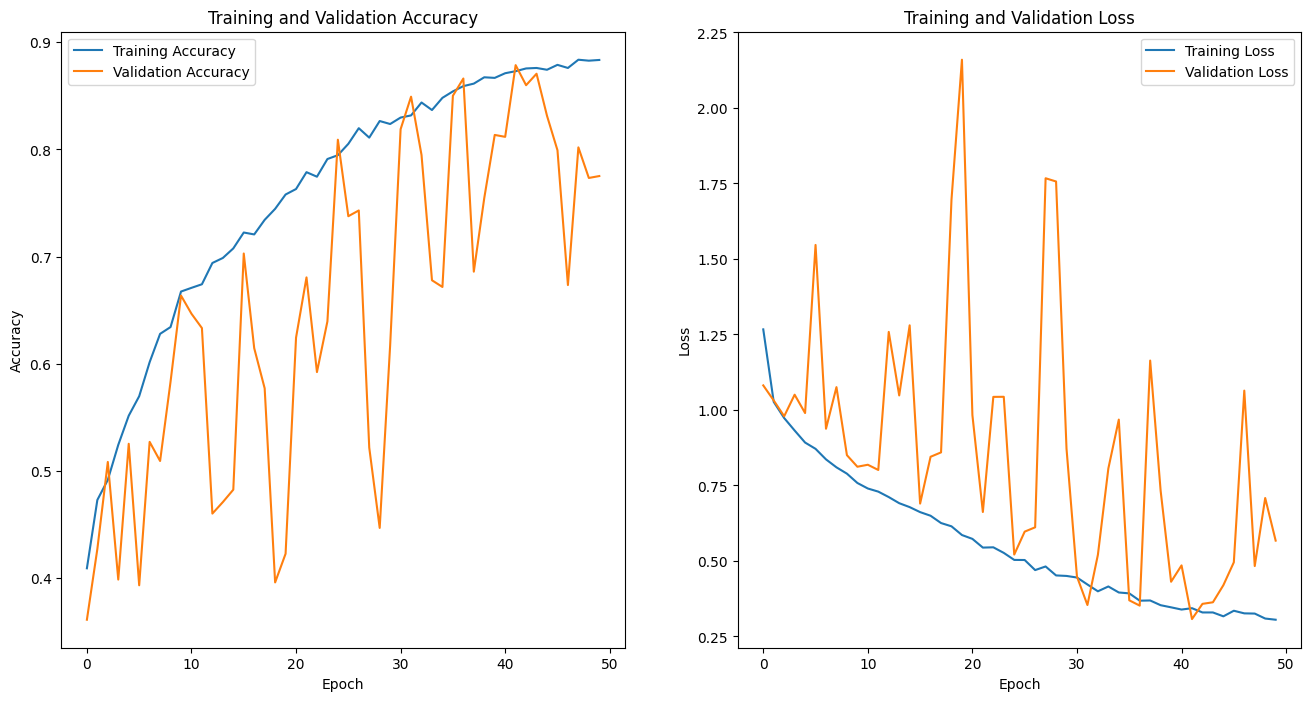

In [122]:
plot_training_history(history4)

In [123]:
print_epoch_logs(history4)

Época 1, Pérdida: 1.2668427228927612, Precisión: 0.4092530608177185
Época 2, Pérdida: 1.02678382396698, Precisión: 0.47302117943763733
Época 3, Pérdida: 0.9731420278549194, Precisión: 0.4917502701282501
Época 4, Pérdida: 0.9319199919700623, Precisión: 0.5244147181510925
Época 5, Pérdida: 0.8920508623123169, Precisión: 0.5516164898872375
Época 6, Pérdida: 0.8711897134780884, Precisión: 0.5697881579399109
Época 7, Pérdida: 0.836266040802002, Precisión: 0.6015607714653015
Época 8, Pérdida: 0.8099647164344788, Precisión: 0.6279821395874023
Época 9, Pérdida: 0.789013683795929, Precisión: 0.6343366503715515
Época 10, Pérdida: 0.7581756711006165, Precisión: 0.667447030544281
Época 11, Pérdida: 0.7398499846458435, Precisión: 0.6709030270576477
Época 12, Pérdida: 0.7295066118240356, Precisión: 0.6742475032806396
Época 13, Pérdida: 0.7114675641059875, Precisión: 0.6940914392471313
Época 14, Pérdida: 0.6912055611610413, Precisión: 0.6987736821174622
Época 15, Pérdida: 0.6782137751579285, Precisió

In [125]:
model4.evaluate(test_dataset)

36/36 [==============================] - 8s 219ms/step - loss: 0.6108 - accuracy: 0.7727


[0.6107835173606873, 0.7727272510528564]

In [126]:
from tensorflow.keras.models import load_model


model_path = 'model_best_4.h5'
prueba = load_model(model_path)

prueba.evaluate(test_dataset)

36/36 [==============================] - 7s 193ms/step - loss: 0.3904 - accuracy: 0.8378


[0.3904135227203369, 0.8377896547317505]

In [127]:
prueba.evaluate(test_dataset)

36/36 [==============================] - 7s 191ms/step - loss: 0.3904 - accuracy: 0.8378


[0.3904135227203369, 0.8377896547317505]

## 5to modelo

In [141]:
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    elif epoch < 30:
        return lr * 0.1
    else:
        return lr * 0.01

lr_scheduler = LearningRateScheduler(scheduler)

In [143]:
model5 = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    # layers.Dense(64, activation='relu'),
    # layers.Dropout(0.5),
    
    layers.Dense(32, activation='relu'),
    
    layers.Dense(N_CLASS, activation='softmax')
])

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_best_5.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  )


callbacks = [early_stop, model_checkpoint, lr_scheduler]

In [144]:
history5 = model5.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks)

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 2.5413 - accuracy: 0.3508
Epoch 1: val_loss improved from inf to 1.09656, saving model to model_best_5.h5
281/281 [==============================] - 237s 839ms/step - loss: 2.5413 - accuracy: 0.3508 - val_loss: 1.0966 - val_accuracy: 0.3747 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.3671
Epoch 2: val_loss did not improve from 1.09656
281/281 [==============================] - 236s 840ms/step - loss: 1.0988 - accuracy: 0.3671 - val_loss: 1.2709 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.3602
Epoch 3: val_loss improved from 1.09656 to 1.08847, saving model to model_best_5.h5
281/281 [==============================] - 236s 838ms/step - loss: 1.0977 - accuracy: 0.3602 - val_loss: 1.0885 - val_accuracy: 0.3657 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - ETA

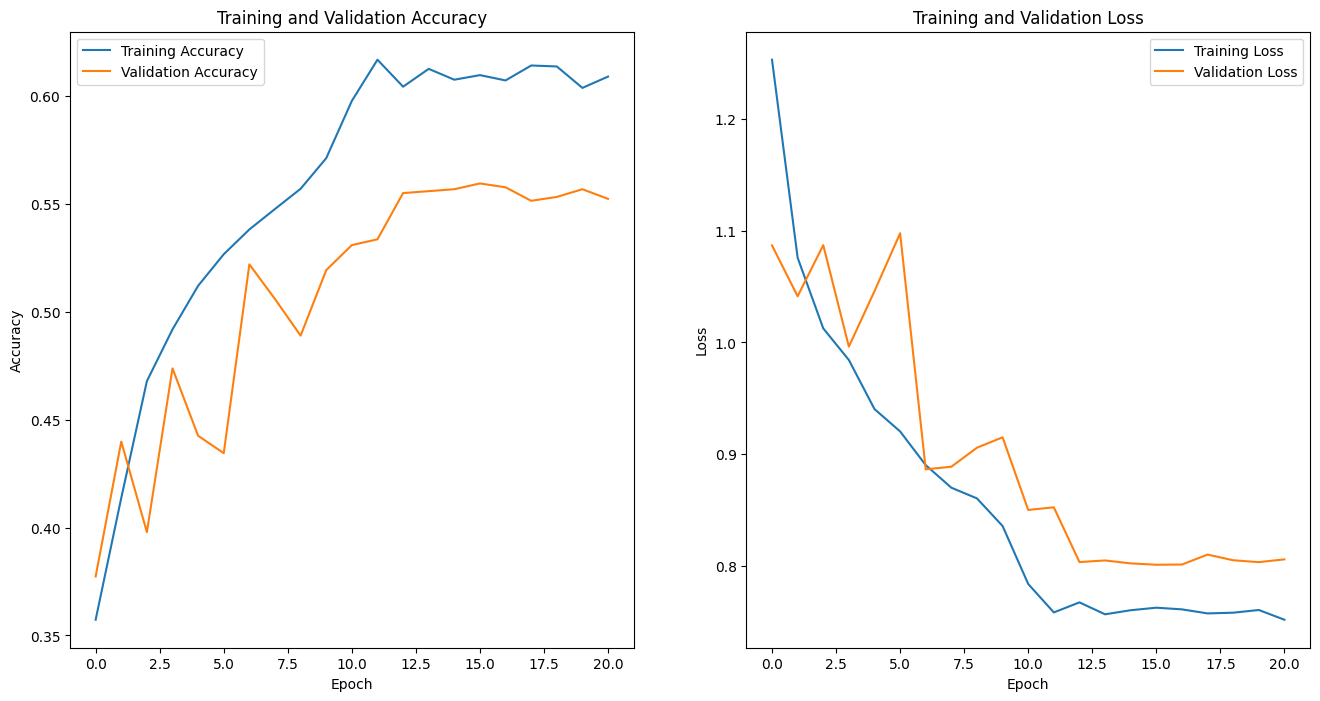

In [132]:
plot_training_history(history5)

In [133]:
print_epoch_logs(history5)

Época 1, Pérdida: 1.253257393836975, Precisión: 0.35730212926864624
Época 2, Pérdida: 1.0759671926498413, Precisión: 0.41371238231658936
Época 3, Pérdida: 1.0126378536224365, Precisión: 0.4677814841270447
Época 4, Pérdida: 0.9843107461929321, Precisión: 0.4917502701282501
Época 5, Pérdida: 0.9403557777404785, Precisión: 0.5119286775588989
Época 6, Pérdida: 0.9203389286994934, Precisión: 0.5265328884124756
Época 7, Pérdida: 0.8901389837265015, Precisión: 0.538015604019165
Época 8, Pérdida: 0.8699207305908203, Precisión: 0.5474916100502014
Época 9, Pérdida: 0.8603416085243225, Precisión: 0.5568562150001526
Época 10, Pérdida: 0.8356218338012695, Precisión: 0.5710144639015198
Época 11, Pérdida: 0.7836900949478149, Precisión: 0.5975473523139954
Época 12, Pérdida: 0.7582169771194458, Precisión: 0.6166109442710876
Época 13, Pérdida: 0.7672132253646851, Precisión: 0.6041248440742493
Época 14, Pérdida: 0.7565323710441589, Precisión: 0.6123746037483215
Época 15, Pérdida: 0.7601799964904785, Prec

## Último modelo

In [181]:
new_model = models.Sequential([
    rescale_resize_layers,
    data_augmentation_layer,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  
    

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASS, activation='softmax')
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,  
    restore_best_weights=True  
)


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_model.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    save_weights_only=False,  
    verbose=1  
)




In [182]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [183]:
def adjusted_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 14:
        return lr * np.exp(-0.1)
    else:
        # Mantén el learning rate constante después de la epoch 14
        return 6.2500e-05

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adjusted_scheduler)
callbacks=[early_stop, model_checkpoint,lr_scheduler]

In [184]:
new_history = new_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,  
    callbacks=callbacks
)


Epoch 1/30


281/281 [==============================] - ETA: 0s - loss: 1.1490 - accuracy: 0.4643
Epoch 1: val_loss improved from inf to 1.25708, saving model to new_model.h5
281/281 [==============================] - 266s 916ms/step - loss: 1.1490 - accuracy: 0.4643 - val_loss: 1.2571 - val_accuracy: 0.3568 - lr: 0.0010
Epoch 2/30
281/281 [==============================] - ETA: 0s - loss: 0.9713 - accuracy: 0.5152
Epoch 2: val_loss improved from 1.25708 to 1.04268, saving model to new_model.h5
281/281 [==============================] - 257s 913ms/step - loss: 0.9713 - accuracy: 0.5152 - val_loss: 1.0427 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 3/30
281/281 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.5511
Epoch 3: val_loss improved from 1.04268 to 0.89437, saving model to new_model.h5
281/281 [==============================] - 255s 906ms/step - loss: 0.9190 - accuracy: 0.5511 - val_loss: 0.8944 - val_accuracy: 0.5558 - lr: 0.0010
Epoch 4/30
281/281 [====================

In [215]:
import pickle



with open('model_history.pkl', 'wb') as file:
    pickle.dump(new_history.history, file)


In [185]:
new_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_27 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_89 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_104 (MaxPool  (None, 127, 127, 32)      0         
 ing2D)                                                          
                                                                 
 dropout_130 (Dropout)       (None, 127, 127, 32)    

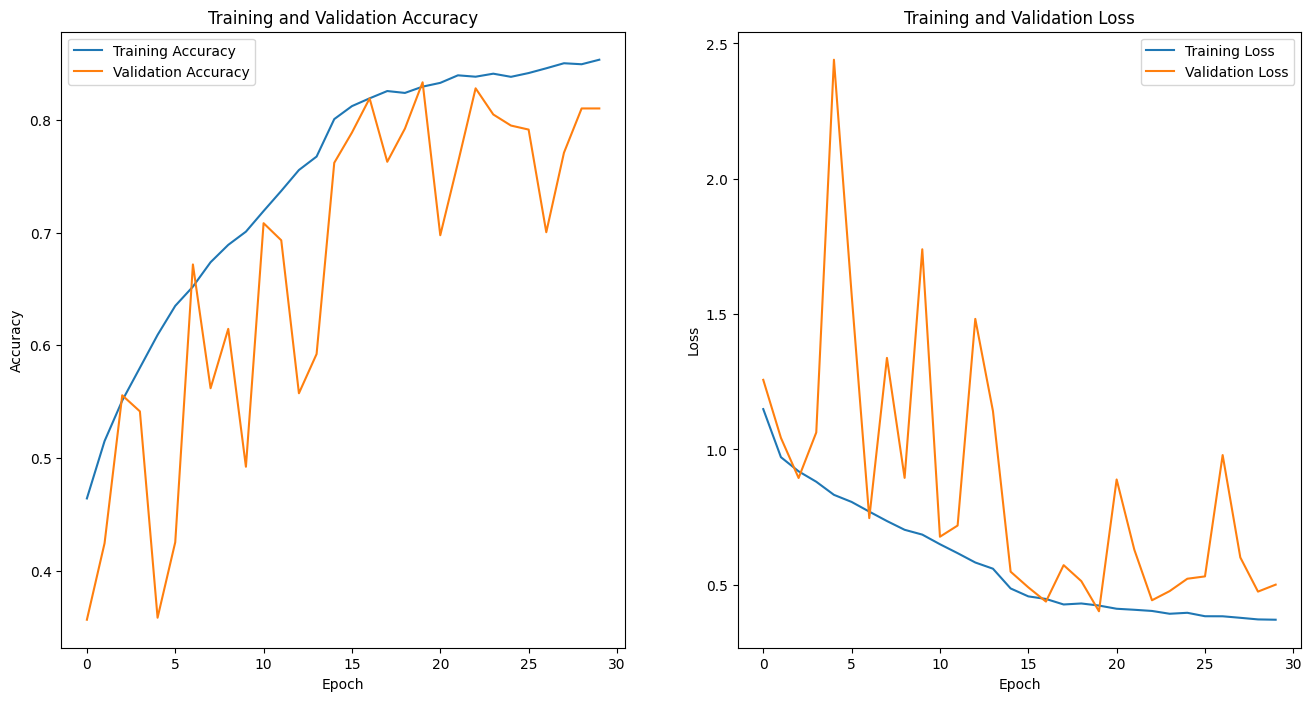

In [186]:
plot_training_history(new_history)

In [187]:
# Procedo a evaluar el modelo en el conjunto de prueba

test_loss, test_accuracy = new_model.evaluate(test_dataset)
print (f'Test Loss:{test_loss},\n Test Accuracy: {test_accuracy}')

36/36 [==============================] - 8s 214ms/step - loss: 0.4942 - accuracy: 0.7977
Test Loss:0.49421873688697815,
 Test Accuracy: 0.7976827025413513


In [188]:
# Una predicción de todo el conjunto de prueba

y_pred = new_model.predict(test_dataset)

# Y las clases

y_pred_classes = np.argmax(y_pred, axis=1)

36/36 [==============================] - 8s 206ms/step


In [189]:
# Obtenemos las etiquetas reales del conjunto de prueba
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [192]:
# Calculamos las métricas de clasificación
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       321
           1       0.74      0.84      0.79       400
           2       0.76      0.72      0.74       401

    accuracy                           0.80      1122
   macro avg       0.81      0.80      0.80      1122
weighted avg       0.80      0.80      0.80      1122



In [193]:
# Calculamos y mostramos la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

[[269  15  37]
 [ 10 338  52]
 [  7 106 288]]


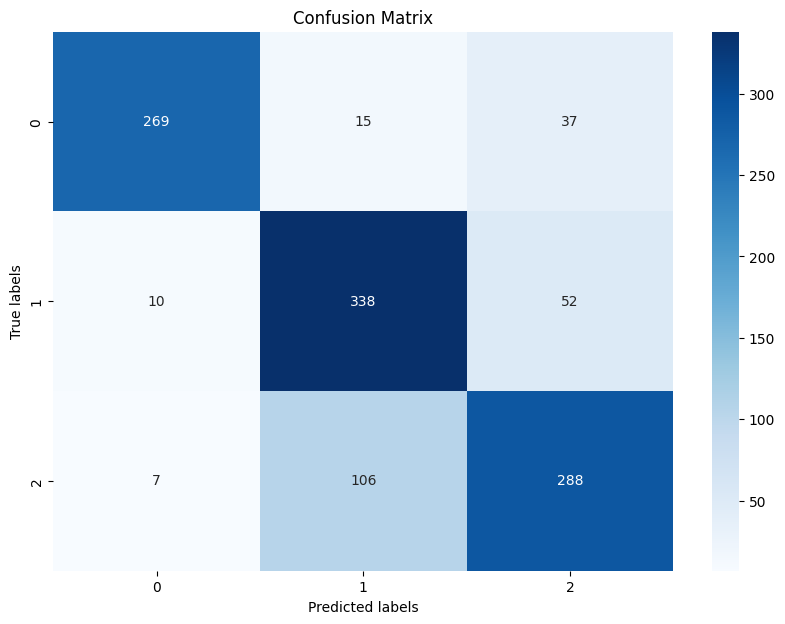

In [200]:
import seaborn as sns

# Graficamos la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 218ms/step


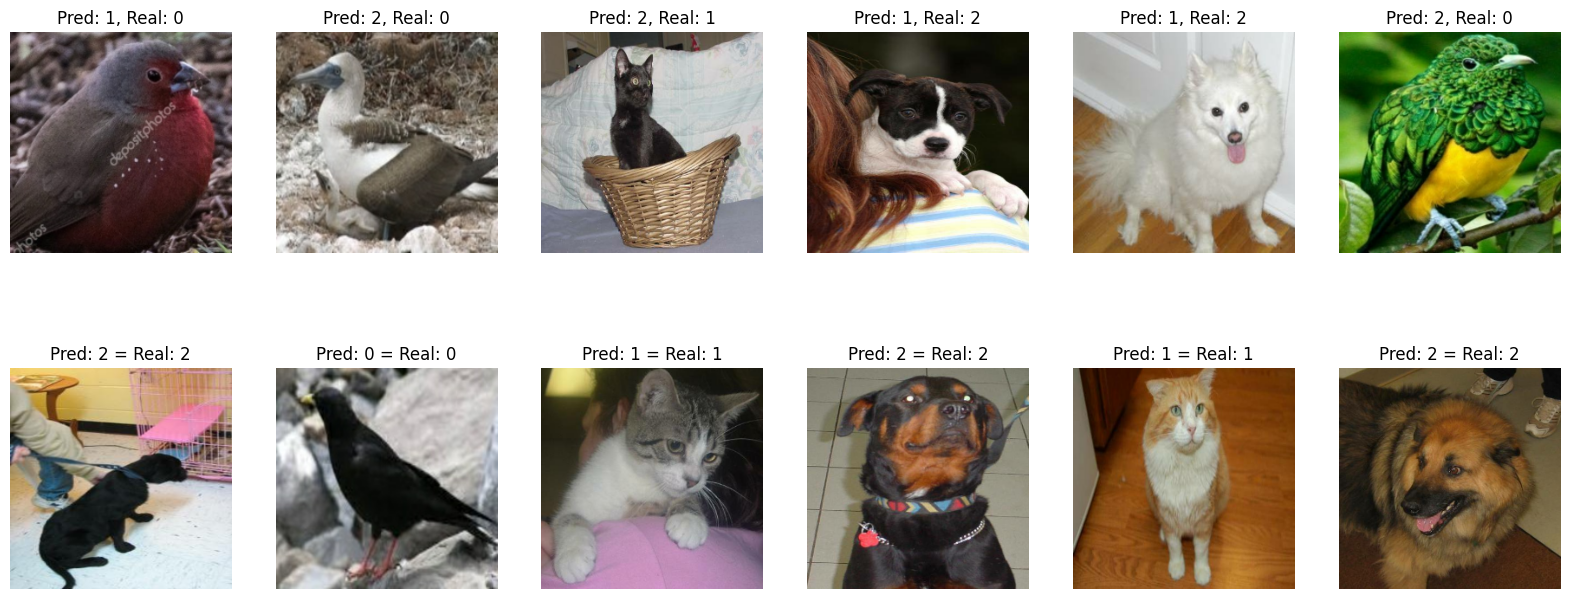

In [208]:
for images, labels in test_dataset.take(1):
    # Hacemos predicciones
    preds = new_model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    
    # Buscamos índices de predicciones incorrectas
    incorrect_indices = np.where(preds_classes != labels.numpy())[0]
    correct_indices = np.where(preds_classes == labels.numpy())[0]
    
    # Ajustamos para mostrar hasta 6 imágenes incorrectas y 6 correctas
    N = 6
    
    plt.figure(figsize=(20, 8))
    
    # Mostramos imágenes incorrectas
    for i, incorrect_index in enumerate(incorrect_indices[:N]):
        plt.subplot(2, N, i + 1)  # Ajustamos para dos filas y N columnas
        plt.imshow(images[incorrect_index].numpy().astype("uint8"))
        plt.title(f'Pred: {preds_classes[incorrect_index]}, Real: {labels[incorrect_index].numpy()}')
        plt.axis('off')
    
    # Mostramos imágenes correctas
    for i, correct_index in enumerate(correct_indices[:N]):
        plt.subplot(2, N, N + i + 1)  # Continuamos en la segunda fila
        plt.imshow(images[correct_index].numpy().astype("uint8"))
        plt.title(f'Pred: {preds_classes[correct_index]} = Real: {labels[correct_index].numpy()}')
        plt.axis('off')
    
    plt.show()

conv2d_104 tiene forma de filtro: (3, 3, 3, 32)


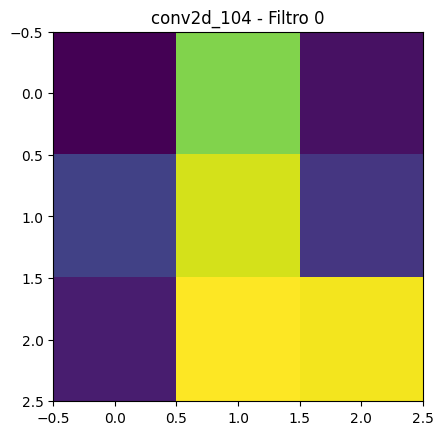

conv2d_105 tiene forma de filtro: (3, 3, 32, 64)


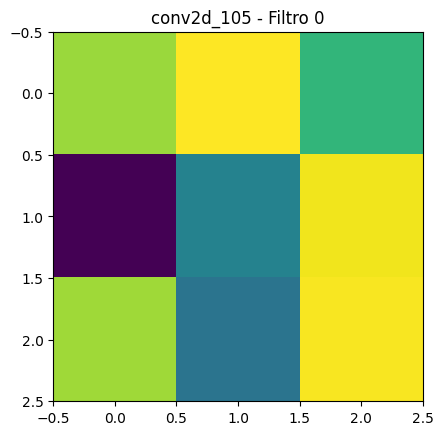

conv2d_106 tiene forma de filtro: (3, 3, 64, 128)


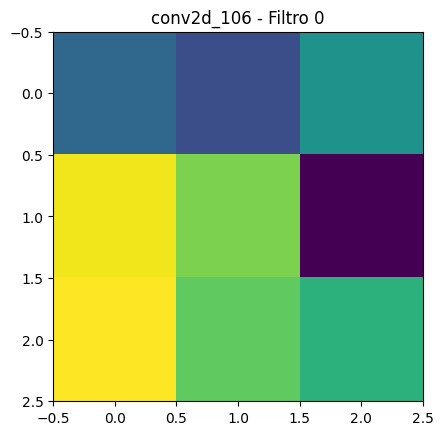

conv2d_107 tiene forma de filtro: (3, 3, 128, 256)


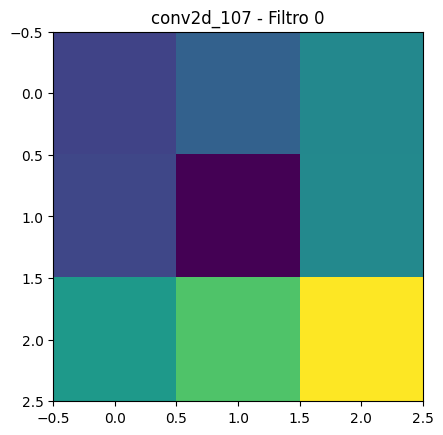

conv2d_108 tiene forma de filtro: (3, 3, 256, 512)


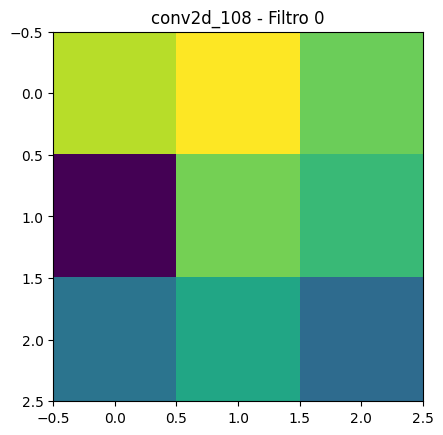

conv2d_109 tiene forma de filtro: (3, 3, 512, 256)


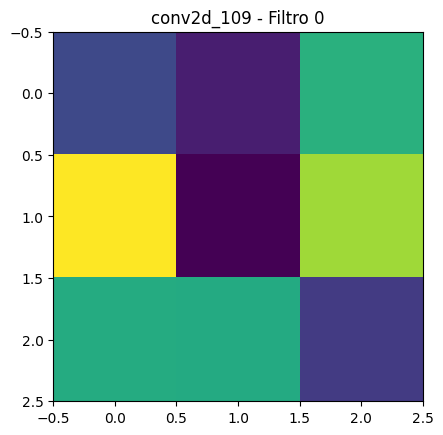

In [209]:
def visualize_filters(model):
    # Iterar sobre las capas del modelo
    for layer in model.layers:
        # Chequear si la capa es convolucional
        if 'conv' in layer.name:
            weights, bias= layer.get_weights()
            print(f"{layer.name} tiene forma de filtro: {weights.shape}")
            
            # Normalizar los valores del filtro para [0, 1] para visualización
            f_min, f_max = weights.min(), weights.max()
            filters = (weights - f_min) / (f_max - f_min)
            
            # Seleccionar un solo filtro para visualizar
            filter_index = 0  # Puedes cambiar este índice para ver diferentes filtros
            selected_filter = filters[:, :, :, filter_index]
            
            # Visualizar el filtro
            fig, ax = plt.subplots()
            ax.imshow(selected_filter[:, :, 0], cmap='viridis')  # Mostrar el primer canal para ejemplificar
            ax.set_title(f"{layer.name} - Filtro {filter_index}")
            plt.show()

visualize_filters(new_model)

In [210]:
# Cargar la imagen
img = load_img('../img/birds/bird_3209.jpg', target_size=(256, 256))  # Ajusta target_size al tamaño de entrada de tu modelo

# Convertir la imagen a un array de numpy
img_array = img_to_array(img)

# Añadir una dimensión para convertir el array en un batch de tamaño 1
img_batch = np.expand_dims(img_array, axis=0)

# Preprocesar la imagen antes de alimentarla al modelo
img_tensor_preprocesado = preprocess_input(img_batch)

1/1 [==============================] - 0s 113ms/step


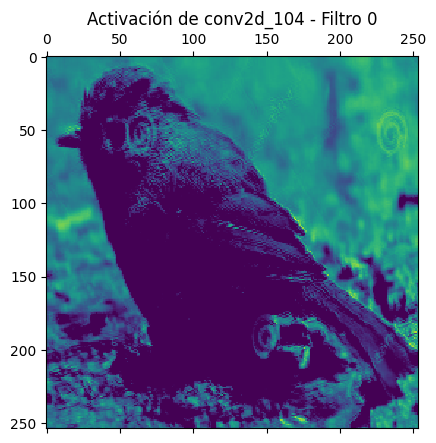

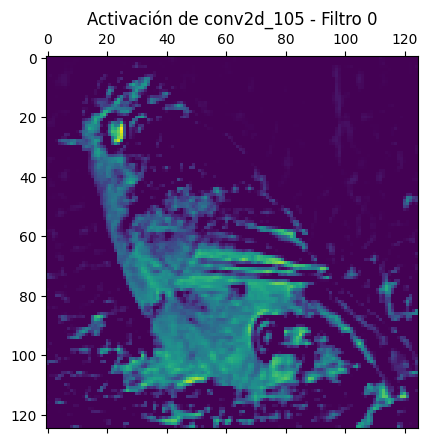

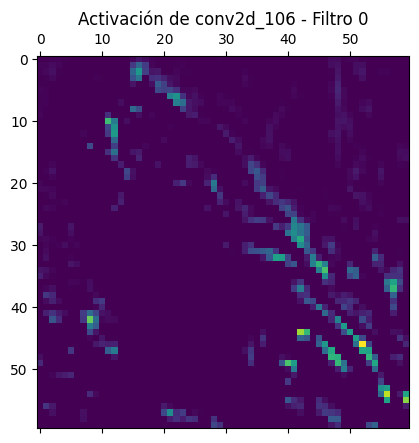

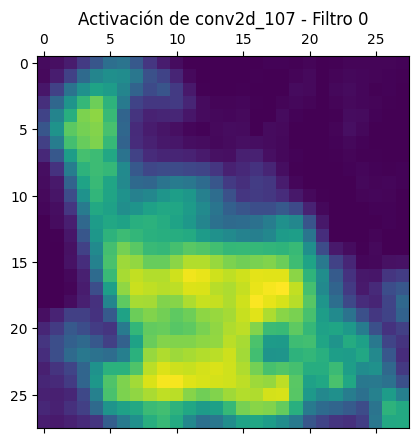

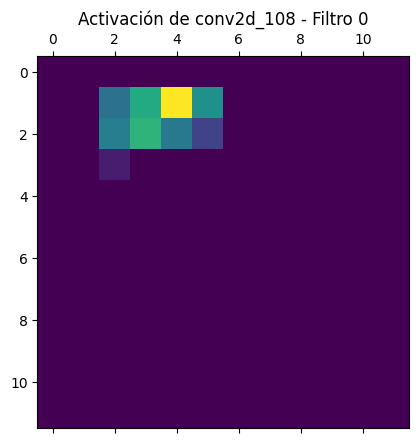

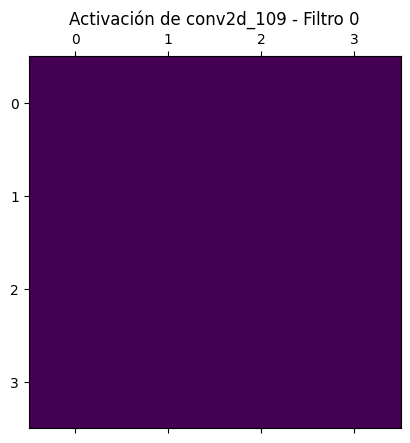

In [213]:
def visualize_activations(model, img_tensor):
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]  # Salidas de las capas convolucionales
    activation_model = Model(inputs=model.input, outputs=layer_outputs)  # Modelo para obtener las activaciones
    activations = activation_model.predict(img_tensor)  # img_tensor es tu imagen preprocesada

    # Visualizar la activación de un filtro específico para cada capa convolucional
    for layer_name, layer_activation in zip([layer.name for layer in model.layers if 'conv' in layer.name], activations):
        filter_index = 0  # Índice del filtro que queremos visualizar
        specific_activation = layer_activation[0, :, :, filter_index]
        
        plt.matshow(specific_activation, cmap='viridis')
        plt.title(f"Activación de {layer_name} - Filtro {filter_index}")
        plt.show()
        
visualize_activations(new_model, img_tensor_preprocesado)